# Estimating an average of a mystery function

We have calculated computational estimates of various quantities. A common property, however, of these was that we had a theoretical value. Let's try doing an estimate where we have no such reference!

A "mystery function" is available as an API, where you can fetch values from. You will need the "requests" library for the following, which you can install by running "pip install requests" in a jupyter notebook. Once that is installed, you can use the following function to fetch $n$ values:

In [1]:
import matplotlib.pyplot as plt
import requests

def get_data(n):
    return requests.get('http://165.22.204.220:8000/', params={'n':n}).json()

In [2]:
def avg(list_of_values):
    return sum(list_of_values) / len(list_of_values)

# Solution to the homework exercise

Doing what we have done before for similar estimation tasks, we can calculate sucessive averages of the data (i.e. calculate the average of larger and larger samples), and plot how that converges:

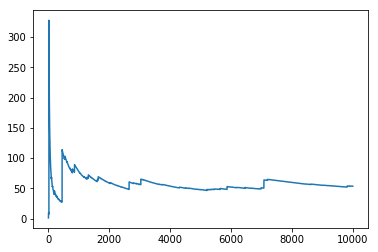

In [3]:
values = get_data(10000)
averages =[ avg(values[:S]) for S in range(1,len(values)) ]
_ = plt.plot(averages)
plt.show()

Looking at this plot, although the curve looks quite different from what we have seen in similar situations before, we might settle on one estimate. To make sure, we might want to run the code again, with, say, twice the maximal sample size:

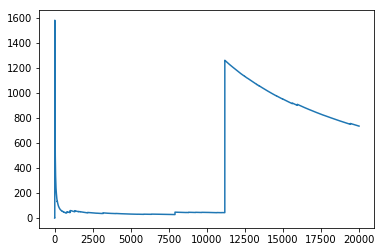

In [4]:
values = get_data(20000)
averages =[ avg(values[:S]) for S in range(1,len(values)) ]
_ = plt.plot(averages)

Again, we get a curve that appears to show some convergence, but to a value that is definately different. Re-runnning the code a few more times will show that this is the general behaviour of the data: we don't really seem to be able to get a convincing estimate, since it appears to change from run to run.

What can we do now?

As mentioned before, one general rule of thumb is: if there is something strange happening with a quantity that is an average, take a look at the values that are being averaged.

We can, for example, simply plot the values before calculating the averages, simply by doing:

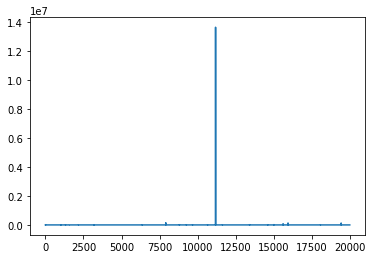

In [5]:
_ = plt.plot(values)

This plot certainly looks quite strange, but the data itself might be more visible if we plot it using individual markers for the datapoints, i.e. not connecting the datapoints:

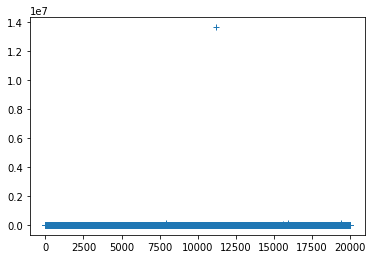

In [6]:
_ = plt.plot(values, '+')

It appears that most of the datapoints fall in a small range of low values, but we have some that are much much larger. In fact, this aspect of the data is already visible on the plot above showing the convergence of the estimate: the strange spikes in that plot is due to these datapoints, since they are so large that they drag the average up a lot, which then "decays" due to the large number of "ordinary" datapoints.

It might be very tempting to consider these large datapoints as outliers -- they certainly appear to be much much larger than the other datapoints and calculating the average might be much easier if we could get rid of them. But before we throw them out, we should look at whether they are actually outliers -- we have seen before, when discussing the in-degree distribution of the word-association network, that datapoints that might seem to be outliers (in that case, the large degree values) might actually be part of a smooth trend.

To check this, we should plot a histogram of the values:

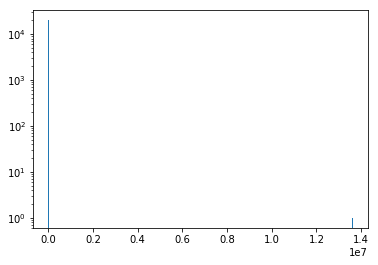

In [7]:
_ = plt.hist(values, bins=1000, log=True)

We quite obviously need to plot using logarithmic scaling, to show the data in some detail. In fact, since there are some small peaks at the right-hand side of the plot, while most of the datapoints are bunched up on the left-hand side of the plot, plotting with log-log scaling (i.e. both axes set to logarithmic) is a good idea:

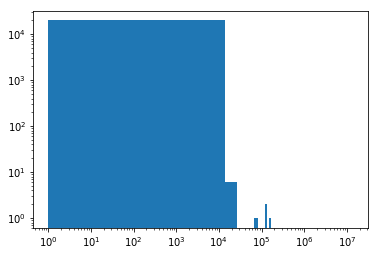

In [8]:
plt.xscale('log')
_ = plt.hist(values, bins=1000, log=True)

This plot looks somewhat hard to interpret -- a large part of the plot is occupied by a single bin, which is both wide and very tall. However, it does show some detail -- the middle part of the plot, if we squint a little, might even look linear. Of course, at the right-hand side of the plot, we see some small peaks which at that point won't really fit in this linear-look trend, but as we have mentioned before, when plotting a histogram of fat-tailed data, the right-hand side will always be broken up into individual peaks as the data thins out in that region.

Considering that the data (or at least a part of it) looks linear in a log-log plot, we might be tempted to fit a power-law to it. This allows us to make some plots, of which the PDF plot is appears particularly interesting:

In [9]:
import powerlaw

In [10]:
fit=powerlaw.Fit(values)

Calculating best minimal value for power law fit
/home/demo/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/home/demo/anaconda3/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


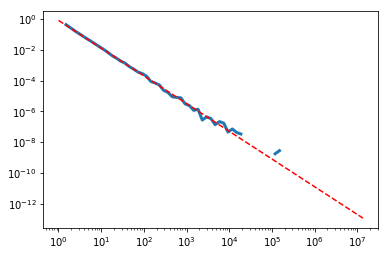

In [11]:
fig = fit.plot_pdf(linewidth=3)
fit.power_law.plot_pdf(ax=fig,color='r',linestyle='--')

As we can see on this plot, not only does the data fit a powerlaw very well, but the entire range of the data appears to fit quite nicely, even the tail on the right-hand side. This plot is a very good argument against treating the very large values as outliers.

The exponent of the fitted powerlaw is:

In [12]:
fit.power_law.alpha

1.7959625986108474

Does this explain the behaviour of the data and the difficulty of obtaining a computational estimate for the average? It might not look like it, but if we recall page 11 from the slides of the 5th lecture (Lecture_05.pdf), it might. That slide shows the following:

<img src="divergences_for_powerlaws.png"></img>

This slide shows that for powerlaw degree distributions, certain quantities, for example the average of the square of the degree (denoted by $\langle k^2 \rangle $) will diverge if the exponent of the powerlaw ($\gamma$) is too small -- note the difference in notation: the slide uses $\gamma$ for the same exponent as the powerlaw python library uses "alpha".

This means that if we have a powerlaw with an exponent that is less than 2, $\langle k \rangle$ will diverge. In our case, where this exponent is around 1.79, this is the case: the quantity we are trying to estimate doesn't actually exist! 

Obviously, if we take a finite sample, we will always be able to calculate the average of that sample, but divergence means that those averages won't converge. This wasn't an issue when calculating previous estimates, since in those cases the quantity being estimated actually existed (we even had a theoretical estimate or value for them), but especially when trying to estimate a quantity without such an assurance, we should keep an eye out for this situation, plot the convergence of our estimate, re-run that plot a few times and in general not be too hasty in jumping to conclusions or in calling something our estimate if the convergence is questionable.

Now that we have understood the issue we faced, I can reveal that the "mystery function" we were estimating is the following:

In [13]:
import networkx

def get_data(n):
    networkx.utils.random_sequence.powerlaw_sequence(n, 1.8)

(The exact code running on the server is a bit more complicated, to deal with handling the http request, json-encoding the result, running a web server, etc.)

I.e. the exact function is a powerlaw with an exponent of 1.8. (The exponent value doesn't exactly match, but is very close to the value we got by fitting a powerlaw to the values we received.)